In [1]:
# just using the bounding box
#### get png and json filepaths

import glob
import os
import re
from PIL import Image

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)

## get the translations (YVALS) from the json files

import os
import json
import numpy as np

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['pose'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


# extract dimensions (XVALS) from the data
from skimage.color import rgb2gray
def model_dimensions(img_np:np.ndarray):

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    try:
        ymin, ymax = np.min(y), np.max(y)
        xmin, xmax = np.min(x), np.max(x)
    except:
        ymin, ymax = 0, 0
        xmin, xmax = 0, 0
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = horiz_sums[horiz_sums>0.01]
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = vert_sums[vert_sums>0.01]
    vert_sums = [i for i in vert_sums]

    # turn the horizontal and vertical sums into a spline, and sample 20 points
    from scipy.interpolate import UnivariateSpline
    horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
    vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
    horiz_spline.set_smoothing_factor(0.5)
    vert_spline.set_smoothing_factor(0.5)

    values_to_query = np.linspace(0, len(horiz_sums), 20)
    horiz_spline_vals = horiz_spline(values_to_query)

    values_to_query = np.linspace(0, len(vert_sums), 20)
    vert_spline_vals  = vert_spline(values_to_query)

    return [height, width, ymin, ymax, xmin, xmax] + list(horiz_spline_vals) + list(vert_spline_vals)


import tqdm
dimensions = []
for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
xvals = dimensions


loading x vals: 100%|██████████| 10000/10000 [02:14<00:00, 74.09it/s]


In [39]:

# CHOOSE TRAINING AND TESTING INDICES

import random
random.seed(42)
data_percent = 0.7
n_pts_to_train = int(data_percent*len(xvals))
n = len(xvals)

indices = list(range(n))
random.shuffle(indices)
train_indices = indices[:n_pts_to_train]
test_indices = indices[n_pts_to_train:]
print(len(train_indices), len(test_indices))

7000 3000


geodesic distance, radians on test Extra trees 0.5080621906461418
geodesic distance, radians on test K-nn 0.54751587
geodesic distance, radians on test Ridge 0.5013603614072064
geodesic distance, radians on test Linear Regression 0.5088194
geodesic distance, radians on test Lasso Linear_0.5 0.49999598


/var/folders/5s/7kml8ttj3pl5l53bkpy_bwlm0000gn/T/ipykernel_69422/338479838.py:36: RuntimeWarning: invalid value encountered in arccos
  return np.pi - 2 * np.arccos(abs(np.sum(pred * target, axis=-1)))


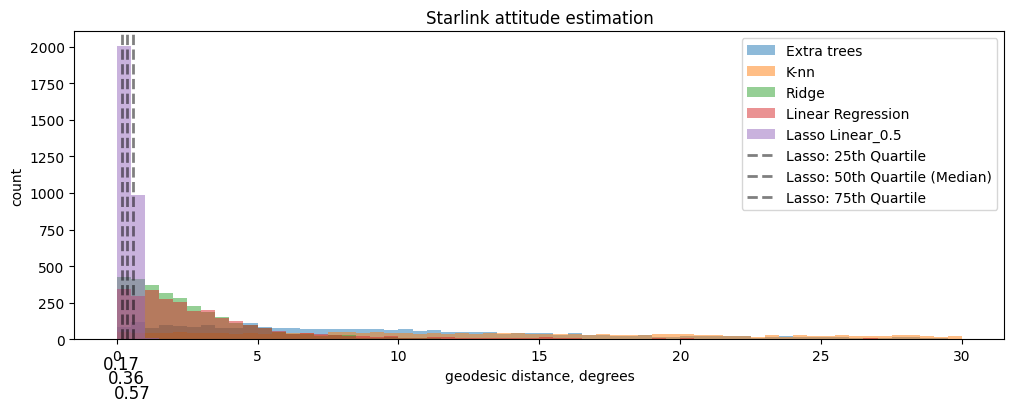

In [40]:
# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    # "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    # "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}


# import numpy as np

# def normalize_quaternion(q):
#     norm = np.linalg.norm(q, axis=-1)
#     return q / norm[...,np.newaxis]

def geodesic_rot_distance(target, pred):
#     # return np.pi - np.arccos(2*np.square(np.sum(pred*target, axis=-1))-1)
#     # target_c = target.copy()
#     # target_c = normalize_quaternion(target_c)
#     # pred_c = pred.copy()
#     # pred_c = normalize_quaternion(pred_c)

    return np.pi - 2 * np.arccos(abs(np.sum(pred * target, axis=-1)))
# from pyquaternion import Quaternion


# def geodesic_rot_distance(target, pred):
#     distances = []
#     for i in range(len(target)):
#         distances.append(Quaternion.distance(Quaternion(target[i]), Quaternion(pred[i])))
#     return np.array(distances)



########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 30
bin_width = 0.5  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)

y_test_predict = dict()
plt.figure(figsize=(12, 4))
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'geodesic distance, radians on test {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    data = geodesic_rot_distance(y_vals[test_indices], y_test_predict[name])*180/np.pi
    plt.hist(data, bins=num_bins, range=(min_bin, max_bin), alpha=0.5, label=name)
    
    if name == 'Lasso Linear_0.5':
        # Calculate QUARTILES values
        q25 = np.percentile(data, 25)
        q50 = np.percentile(data, 50)
        q75 = np.percentile(data, 75)

        # Add vertical lines for quartiles
        plt.axvline(q25, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Lasso: 25th Quartile')
        plt.axvline(q50, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Lasso: 50th Quartile (Median)')
        plt.axvline(q75, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Lasso: 75th Quartile')
        
        plt.text(q25, -200, f'{q25:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q50, -300, f'{q50:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q75, -400, f'{q75:.2f}', color='black', fontsize=12, ha='center')

    plt.title('Starlink attitude estimation')
    plt.xlabel('geodesic distance, degrees')
    plt.ylabel('count')
    plt.legend()
    # plt.show()


loading x vals: 100%|██████████| 10000/10000 [02:06<00:00, 78.96it/s]


geodesic distance, radians on test Extra trees 0.5080621906461418
geodesic distance, radians on test K-nn 0.54751587
geodesic distance, radians on test Ridge 0.5013603614072064
geodesic distance, radians on test Linear Regression 0.5088194
geodesic distance, radians on test Lasso Linear_0.5 0.49999598


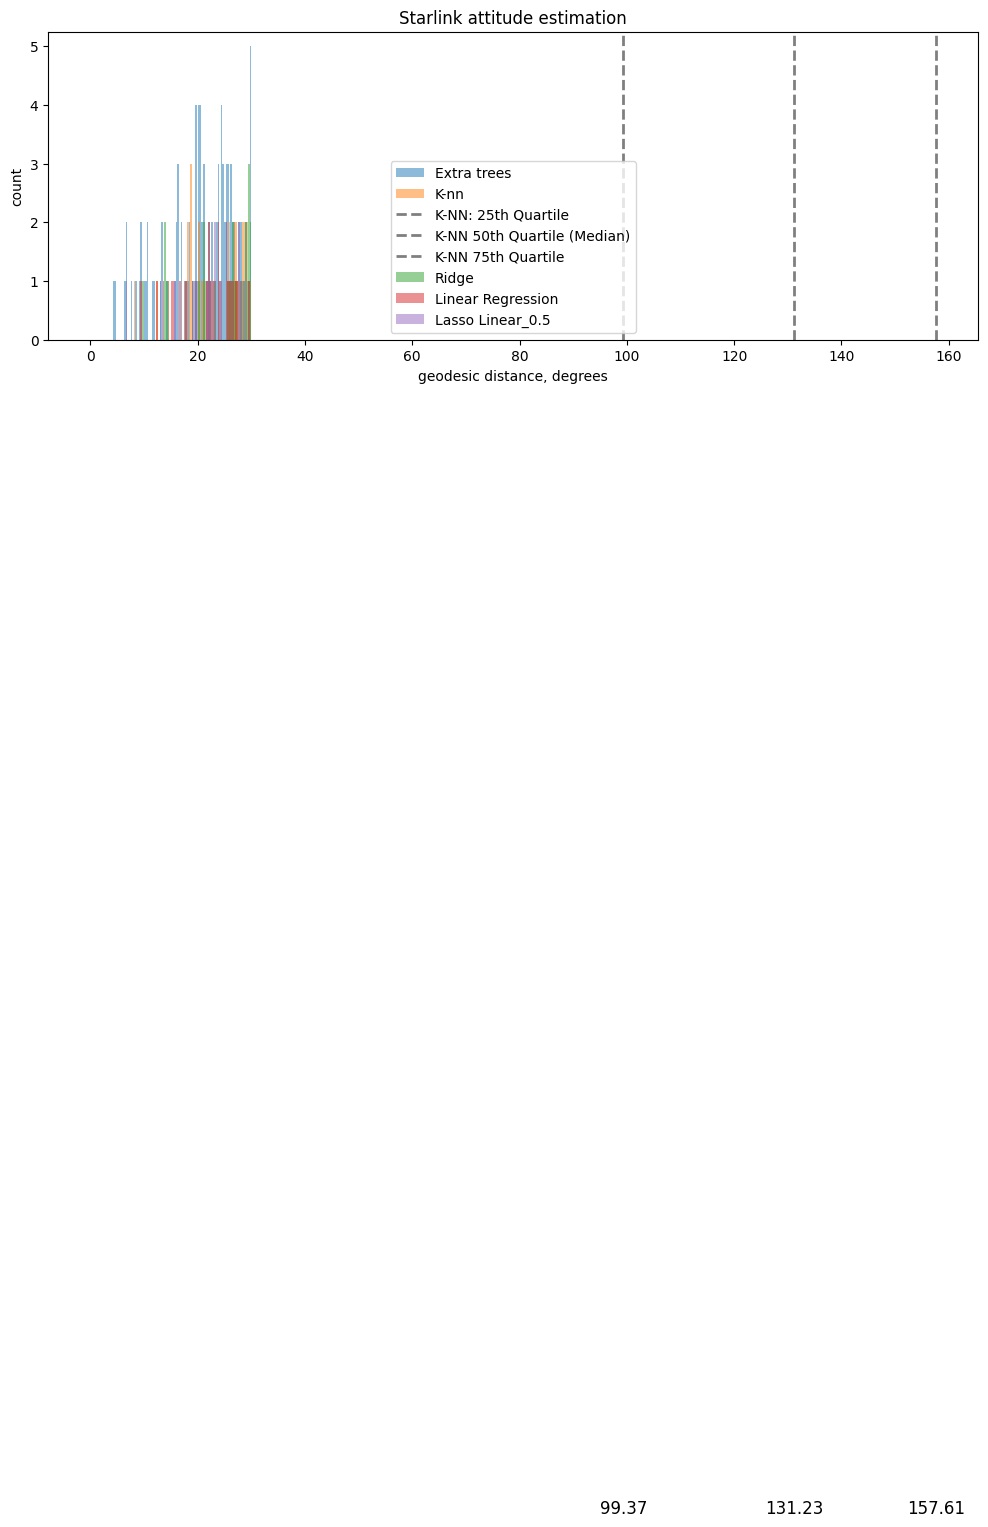

In [5]:
# more interpolation

# just using the bounding box
#### get png and json filepaths

import glob
import os
import re
from PIL import Image

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)

## get the translations (YVALS) from the json files

import os
import json
import numpy as np

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['pose'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


interp_samples = 50
# extract dimensions (XVALS) from the data
from skimage.color import rgb2gray
def model_dimensions(img_np:np.ndarray):

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    try:
        ymin, ymax = np.min(y), np.max(y)
        xmin, xmax = np.min(x), np.max(x)
    except:
        ymin, ymax = 0, 0
        xmin, xmax = 0, 0
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = horiz_sums[horiz_sums>0.01]
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = vert_sums[vert_sums>0.01]
    vert_sums = [i for i in vert_sums]

    # turn the horizontal and vertical sums into a spline, and sample 20 points
    from scipy.interpolate import UnivariateSpline
    horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
    vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
    horiz_spline.set_smoothing_factor(0.5)
    vert_spline.set_smoothing_factor(0.5)

    values_to_query = np.linspace(0, len(horiz_sums), interp_samples)
    horiz_spline_vals = horiz_spline(values_to_query)

    values_to_query = np.linspace(0, len(vert_sums), interp_samples)
    vert_spline_vals  = vert_spline(values_to_query)

    return [height, width, ymin, ymax, xmin, xmax] + list(horiz_spline_vals) + list(vert_spline_vals)


import tqdm
dimensions = []
for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
xvals = dimensions


# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    # "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    # "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

import torch
def geodesic_rot_distance(target, pred):
    
    target = torch.tensor(target)
    pred = torch.tensor(pred)
    
    ndims = len(target.shape)
    # first, normalise each quaternion
    pred   = torch.nn.functional.normalize(pred, p=2, dim=ndims-1)
    target = torch.nn.functional.normalize(target, p=2, dim=ndims-1) # <- targets are already normalised

    # compute angular distance
    inner_prod_square = torch.square(torch.sum(pred*target, dim=ndims-1))
    theta = torch.arccos(2*inner_prod_square-1)
    return theta

########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 180
bin_width = 30  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)

y_test_predict = dict()
plt.figure(figsize=(12, 4))
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'geodesic distance, radians on test {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    data = geodesic_rot_distance(y_vals[test_indices], y_test_predict[name])*180/np.pi
    plt.hist(data, bins=num_bins, range=(min_bin, max_bin), alpha=0.5, label=name)
    
    if name == 'K-nn':
        # Calculate QUARTILES values
        q25 = np.percentile(data, 25)
        q50 = np.percentile(data, 50)
        q75 = np.percentile(data, 75)

        # Add vertical lines for quartiles
        plt.axvline(q25, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='K-NN: 25th Quartile')
        plt.axvline(q50, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='K-NN 50th Quartile (Median)')
        plt.axvline(q75, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='K-NN 75th Quartile')
        
        plt.text(q25, -20, f'{q25:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q50, -20, f'{q50:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q75, -20, f'{q75:.2f}', color='black', fontsize=12, ha='center')

    plt.title('Starlink attitude estimation')
    plt.xlabel('geodesic distance, degrees')
    plt.ylabel('count')
    plt.legend()
    # plt.show()

